## <div style="text-align: right"> Mayank Pathak </div>
# Problem Set 3
## Question 2 
### Classifying Adult Dataset 

### October 20, 2018

- 1. **Introduction** 
    - 1.1 Importing Necessary libraries
    - 1.2 Defining Hyper-Parameters
- 2. **Data Preparation**
    - 2.1  Load Data
    - 2.2  Creating Dataset
    - 2.3  Creating Data Loader
- 3. **Neural Network**
    - 3.1 Module Class for network
    - 3.2 Function to implement testing
    - 3.3 Function to adjust learning rate 
    - 3.4 Function to implement training
- 4. **Evaluate Model**
    - 4.1 Plot Accuracy and Loss curves

### 1. Introduction

#### 1.1 Importing necessary libraries:
Libraries used for to create this network:
    1. numpy
    2. matplotlib
    3. torch
    4. sklearn
    5. torch vision
    6. os

In [363]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch import autograd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torch.autograd.variable import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

%matplotlib inline

#### 1.2 Defining Hyper-Parameters and other required Parameters
The Hyper-Parameters for this model are:

   1. **batch size:** batch size of 50 comes out to be giving good results and speed
   2. **learning rate:** learning rate is used as 0.001
   3. **weight decay:** standard weight decay is used as 0.0001. I tried other values, however this value works best
   4. **epochs:** The network saturates after 17 epochs. total epochs kept: 20.
   5. **optimizer:** After trying SGD and other optimizers, I used Adam optimizer.

In [364]:
# parameters

batch_size = 50
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 20
input_size = 67
num_classes = 2

### 2. Data Preparation

#### 2.1 Load Data
The input images and labels are loaded using 'np.load' function to load the '.npy' files provided with the homework assignment. <br>

> Number of Input Data : 45222 <br>

In [365]:
input_data = np.load('Adult/data.npy').astype('float32')
input_labels = np.load('Adult/labels.npy').astype('float32')



the input data is then split between training and testing with 15% data kept for testing.

> TrainImages shape: (36177) <br>
> TestImages shape: (9045)

In [366]:
train_data, test_data, train_labels, test_labels = train_test_split(input_data,input_labels,
                                                    test_size=0.15)

#### 2.2 Creating Dataset
Input data and label are converted to tensor and are then wrapped into tensor Dataset 

In [377]:

#Create a training set
tensor_x = torch.from_numpy(train_data).float()
tensor_y = torch.from_numpy(train_labels).long()
train_set = Data.TensorDataset(tensor_x,tensor_y)

#Create a test set
tensor_x = torch.from_numpy(test_data).float()
tensor_y = torch.from_numpy(test_labels).long()
test_set = Data.TensorDataset(tensor_x,tensor_y)


#### 2.3 Creating Data Loader
The dataset created above is used to make data loader of defined batch size. The data for training is shuffled for every epoch while it is not for testing.

In [378]:
train_loader = Data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle= True)

test_loader = Data.DataLoader(dataset = test_set, batch_size=batch_size, shuffle=False)


### Neural Network

#### 3.1 Module Class for network
To implement the network using pytorch, a class 'Net' is created with argument 'nn.Module' which allows to use it as a network. It makes the network implementation easier.

In [369]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 35),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(35, 55),
            nn.ReLU())
        self.dout = nn.Dropout(0.2)
        self.fc3 = nn.Sequential(
            nn.Linear(55,35),
            nn.ReLU())
        self.fc4 = nn.Sequential(
            nn.Linear(35,num_classes))
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.dout(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

#### 3.2 Function to implement testing
The data is loaded with the test loader and predicted output is compared with the actual output.

In [370]:
def test():
    model.eval()
    test_acc = 0.0
    for i, (data, labels) in enumerate(test_loader):

        # Predict classes using images from the test set
        data = Variable(data)
        labels = Variable(labels)
        outputs = model(data)
        _, prediction = torch.max(outputs.data, 1)
        
#         prediction = prediction.data
#         prediction =
        test_acc = (i*test_acc +
                    torch.mean(prediction.eq(labels.data).float()))/(i+1)

    # Compute the average acc and loss over all 10000 test images
#     test_acc = test_acc / 10000

    return test_acc

#### 3.3 Function to adjust learning rate 
The initial learning rate for the network is taken as 0.001. The learning rate is then adjusted rate as the network progresses with the epochs. Please see the below code cell for more details:

In [371]:

# Create a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
def adjust_learning_rate(epoch):
    lr = learning_rate

    if epoch > 100:
        lr = lr / 1000000
    elif epoch > 50:
        lr = lr / 100000
    elif epoch > 20:
        lr = lr / 10000
    elif epoch > 10:
        lr = lr / 1000
    elif epoch > 5:
        lr = lr / 100
    elif epoch > 2:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

Object for the class is created and loss function is defined

In [372]:
model = Net(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay, betas = (0.9,0.999))

#### 3.4 Function to implement training
below code cell runs the training loop for the given number of epochs and calcualtes the parameters. </br>
It also calls the testing function at every epoch.

In [373]:
def train(num_epochs):
    best_acc = 0.0
    test_accuracies = []
    train_accuracies = []
    train_losses = []
    for epoch in range(num_epochs):
        print('-'*10)
        print("Epoch: {}/{} \n".format(epoch+1,num_epochs))
    #     losses = []
        train_acc = 0.0
        train_loss = 0.0
        model.train()
        for i ,(x, y) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs =  Variable(x)
            output = model(inputs)
            targets = Variable(y.squeeze(-1))
            targets = targets.type(torch.LongTensor)
            
#             print(type(output))
#             output = output.type(torch.LongTensor)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            y = Variable(y)
            train_loss = (train_loss*i + loss.data[0])/(i+1)
            _, prediction = torch.max(output.data, 1)

            train_acc = (i*train_acc +
                 torch.mean(prediction.eq(y.data).float()))/(i+1)
    #         break
            adjust_learning_rate(epoch)
            train_losses.append(train_loss)
            
#     break
        # Evaluate on the test set
        test_acc = test()
        test_accuracies.append(test_acc)
        train_accuracies.append(train_acc)
        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
#             save_models(epoch)
            best_acc = test_acc
            

        # Print the metrics
        print("Train Accuracy: {:.6f}% , TrainLoss: {:.4f}, \nTest Accuracy: {:.6f} %".format(train_acc*100, train_loss,test_acc*100))
    print('\n\nbest_acc = {:.4f}% '.format(best_acc*100))
    
    return test_accuracies,train_accuracies, train_losses

__Training Function is called to execute the network__

In [374]:
if __name__ == "__main__":
    print("Started Training Network")
    test_accuracies,train_accuracies, train_losses = train(num_epochs)
    print("\n\nFinished !!")
test_accuracies = [i*100 for i in test_accuracies]
train_accuracies = [i*100 for i in train_accuracies]

Started Training Network
----------
Epoch: 1/20 

Train Accuracy: 81.011156% , TrainLoss: 0.4046, 
Test Accuracy: 81.641869 %
----------
Epoch: 2/20 

Train Accuracy: 83.497365% , TrainLoss: 0.3507, 
Test Accuracy: 83.480104 %
----------
Epoch: 3/20 

Train Accuracy: 84.034905% , TrainLoss: 0.3432, 
Test Accuracy: 84.002595 %
----------
Epoch: 4/20 

Train Accuracy: 84.541236% , TrainLoss: 0.3314, 
Test Accuracy: 84.164360 %
----------
Epoch: 5/20 

Train Accuracy: 84.588871% , TrainLoss: 0.3300, 
Test Accuracy: 83.950692 %
----------
Epoch: 6/20 

Train Accuracy: 84.615016% , TrainLoss: 0.3289, 
Test Accuracy: 84.112457 %
----------
Epoch: 7/20 

Train Accuracy: 84.776264% , TrainLoss: 0.3273, 
Test Accuracy: 84.200692 %
----------
Epoch: 8/20 

Train Accuracy: 84.748340% , TrainLoss: 0.3272, 
Test Accuracy: 84.303633 %
----------
Epoch: 9/20 

Train Accuracy: 84.783109% , TrainLoss: 0.3270, 
Test Accuracy: 84.185986 %
----------
Epoch: 10/20 

Train Accuracy: 84.717268% , TrainLoss: 

### 4. Evaluate Model
#### 4.1 Output Plots

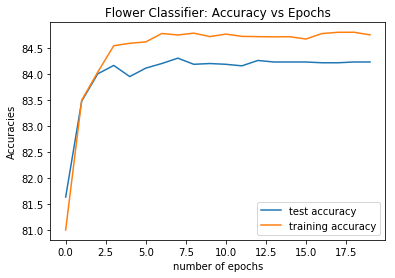

In [375]:

# plot the training progress
plt.plot(range(0, len(test_accuracies)), test_accuracies, range(0, len(train_accuracies)), train_accuracies)
plt.xlabel('number of epochs')
# plt.xlim([0, len(train_loss)])
plt.ylabel('Accuracies')
# plt.ylim([0.0, 1.0])
plt.title('Flower Classifier: Accuracy vs Epochs')
plt.legend(['test accuracy','training accuracy'])

Text(0.5, 1.0, 'Flower Classifier: Loss vs Epochs')

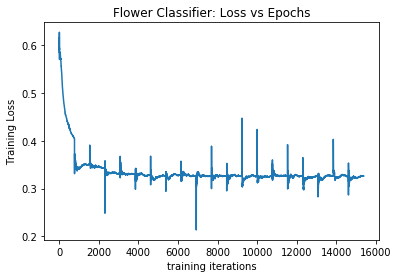

In [376]:
# plot the training progress
plt.plot(range(0, len(train_losses)), train_losses)
plt.xlabel('training iterations')
# plt.xlim([0, len(train_loss)])
plt.ylabel('Training Loss')
# plt.ylim([0.0, 1.0])
plt.title('Flower Classifier: Loss vs Epochs')